In [9]:
import numpy
import scipy.io
import matplotlib.pyplot as plt
%matplotlib inline

In [11]:
#Open ROMS grid file
if 'nc' not in vars(): nc = scipy.io.netcdf_file('CCS_7k_0-360_fred_grd.nc')

In [12]:
nj,ni = nc.variables['lon_rho'].shape
nj -=2; ni -=2
print('nj=%i, nj=%i'%(nj,ni))

nj=480, nj=180


In [13]:
# Supergrid shape
snj,sni = 2*numpy.array([nj,ni]) # Smallest useful super-grid has a multiplier of 2

# Declare shapes
lon = numpy.zeros((snj+1,sni+1))
lat = numpy.zeros((snj+1,sni+1))
area = numpy.zeros((snj,sni))
dx = numpy.zeros((snj+1,sni))
dy = numpy.zeros((snj,sni+1))
angle = numpy.zeros((snj+1,sni+1))

# Copy in data from ROMS file
lon[::2,::2] = nc.variables['lon_psi'][:,:] # Cell corners
lon[1::2,1::2] = nc.variables['lon_rho'][1:-1,1:-1] # Cell centers (drop outside row and column)
lon[1::2,::2] = nc.variables['lon_u'][1:-1,:] # U-points (drop outside row)
lon[::2,1::2] = nc.variables['lon_v'][:,1:-1] # V-points (drop outside column)
lat[::2,::2] = nc.variables['lat_psi'][:,:] # Cell corners
lat[1::2,1::2] = nc.variables['lat_rho'][1:-1,1:-1] # Cell centers (drop outside row and column)
lat[1::2,::2] = nc.variables['lat_u'][1:-1,:] # U-points (drop outside row)
lat[::2,1::2] = nc.variables['lat_v'][:,1:-1] # V-points (drop outside column)

def angle_p1p2(p1, p2):
    """Angle at center of sphere between two points on the surface of the sphere.
    Positions are given as (latitude,longitude) tuples measured in degrees."""
    phi1 = numpy.deg2rad( p1[0] )
    phi2 = numpy.deg2rad( p2[0] )
    dphi_2 = 0.5 * ( phi2 - phi1 )
    dlambda_2 = 0.5 * numpy.deg2rad( p2[1] - p1[1] )
    a = numpy.sin( dphi_2 )**2 + numpy.cos( phi1 ) * numpy.cos( phi2 ) * ( numpy.sin( dlambda_2 )**2 )
    c = 2. * numpy.arctan2( numpy.sqrt(a), numpy.sqrt( 1. - a ) )
    return c
# Approximate edge lengths as great arcs
R = 6370.e3 # Radius of sphere
dx[:,:] = R*angle_p1p2( (lat[:,1:],lon[:,1:]), (lat[:,:-1],lon[:,:-1]) )
dy[:,:] = R*angle_p1p2( (lat[1:,:],lon[1:,:]), (lat[:-1,:],lon[:-1,:]) )

# Approximate angles using centered differences in interior
angle[:,1:-1] = numpy.arctan( (lat[:,2:]-lat[:,:-2]) / ((lon[:,2:]-lon[:,:-2])*numpy.cos(numpy.deg2rad(lat[:,1:-1]))) )
# Approximate angles using side differences on left/right edges
angle[:,0] = numpy.arctan( (lat[:,1]-lat[:,0]) / ((lon[:,1]-lon[:,0])*numpy.cos(numpy.deg2rad(lat[:,0]))) )
angle[:,-1] = numpy.arctan( (lat[:,-1]-lat[:,-2]) / ((lon[:,-1]-lon[:,-2])*numpy.cos(numpy.deg2rad(lat[:,-1]))) )

def spherical_angle(v1, v2, v3):
    """Returns angle v2-v1-v3 i.e betweeen v1-v2 and v1-v3."""
    # vector product between v1 and v2
    px = v1[1]*v2[2] - v1[2]*v2[1]
    py = v1[2]*v2[0] - v1[0]*v2[2]
    pz = v1[0]*v2[1] - v1[1]*v2[0]
    # vector product between v1 and v3
    qx = v1[1]*v3[2] - v1[2]*v3[1]
    qy = v1[2]*v3[0] - v1[0]*v3[2]
    qz = v1[0]*v3[1] - v1[1]*v3[0]

    ddd = (px*px+py*py+pz*pz)*(qx*qx+qy*qy+qz*qz)
    ddd = (px*qx+py*qy+pz*qz) / numpy.sqrt(ddd)
    angle = numpy.arccos( ddd );
    return angle
def spherical_quad(lat,lon):
    """Returns area of spherical quad (bounded by great arcs)."""
    # x,y,z are 3D coordinates
    d2r = numpy.deg2rad(1.)
    x = numpy.cos(d2r*lat)*numpy.cos(d2r*lon)
    y = numpy.cos(d2r*lat)*numpy.sin(d2r*lon)
    z = numpy.sin(d2r*lat)
    c0 = (x[:-1,:-1],y[:-1,:-1],z[:-1,:-1])
    c1 = (x[:-1,1:],y[:-1,1:],z[:-1,1:])
    c2 = (x[1:,1:],y[1:,1:],z[1:,1:])
    c3 = (x[1:,:-1],y[1:,:-1],z[1:,:-1])
    a0 = spherical_angle( c1, c0, c2)
    a1 = spherical_angle( c2, c1, c3)
    a2 = spherical_angle( c3, c2, c0)
    a3 = spherical_angle( c0, c3, c1)
    return a0+a1+a2+a3-2.*numpy.pi
# Approximate cell areas as that of spherical polygon
area[:,:] = R*R*spherical_quad(lat,lon)

In [14]:
# Create a mosaic file
rg = scipy.io.netcdf_file('ocean_hgrid.nc','w')
# Dimensions
rg.createDimension('nx',sni)
rg.createDimension('nxp',sni+1)
rg.createDimension('ny',snj)
rg.createDimension('nyp',snj+1)
rg.createDimension('string',5)
# Variables
hx = rg.createVariable('x','float32',('nyp','nxp',))
hx.units = 'degrees'
hy = rg.createVariable('y','float32',('nyp','nxp',))
hy.units = 'degrees'
hdx = rg.createVariable('dx','float32',('nyp','nx',))
hdx.units = 'meters'
hdy = rg.createVariable('dy','float32',('ny','nxp',))
hdy.units = 'meters'
harea = rg.createVariable('area','float32',('ny','nx',))
harea.units = 'meters^2'
hangle = rg.createVariable('angle_dx','float32',('nyp','nxp',))
hangle.units = 'degrees'
htile = rg.createVariable('tile','c',('string',))
# Values
hx[:] = lon
hy[:] = lat
hdx[:] = dx
hdy[:] = dy
harea[:] = area
hangle[:] = angle
htile[:5] = 'tile1'
rg.close()

In [15]:
# Create a topography file
rg = scipy.io.netcdf_file('ocean_topog.nc','w')
# Dimensions
rg.createDimension('nx',ni)
rg.createDimension('ny',nj)
rg.createDimension('ntiles',1)
# Variables
hdepth = rg.createVariable('depth','float32',('ny','nx',))
hdepth.units = 'm'
# Values
hdepth[:] = nc.variables['hraw'][0,1:-1,1:-1]
rg.close()

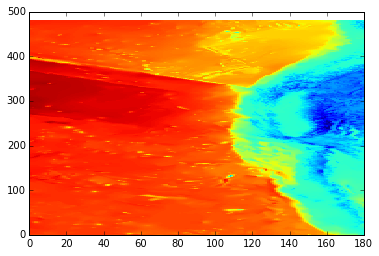

In [17]:
plt.pcolormesh(hdepth[:])

In [22]:
import sys
sys.argv=['--output topog.nc','ocean_topog.nc']
execfile('ice9.py')

Range of input depths: min= -5495.5 max= 3774.86
File "iced_ocean_topog.nc" written.


/home/mjh/anaconda/lib/python2.7/site-packages/scipy/io/netcdf.py:287: RuntimeWarning: Cannot close a netcdf_file opened with mmap=True, when netcdf_variables or arrays referring to its data still exist. All data arrays obtained from such files refer directly to data on disk, and must be copied before the file can be cleanly closed. (See netcdf_file docstring for more information on mmap.)
  ), category=RuntimeWarning)


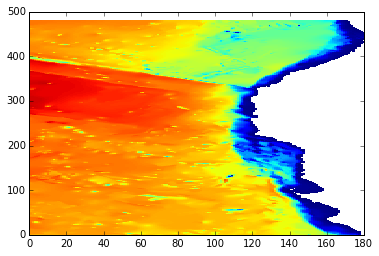

In [25]:
nc2=scipy.io.netcdf_file('iced_ocean_topog.nc')
hdepth2=nc2.variables['depth']
plt.pcolormesh(np.ma.masked_where(hdepth2[:]<10,hdepth2[:]))